# Graph Analysis - Mathieu VANDECASTEELE

# Maximum Common Induced Subgraph in Python3 Demonstration

In [26]:
# Useful Imports
from graph import *
from mcs import *
from utils import *
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.cbook
import warnings
import time
from networkx.algorithms import approximation
warnings.filterwarnings("ignore")

# Maximum Common Induced Subgraph

In [12]:
M = nx.dense_gnm_random_graph(10,20)
M2 = nx.dense_gnm_random_graph(10,20)

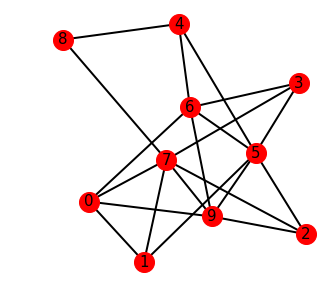

In [13]:
display_nxgraph(M)

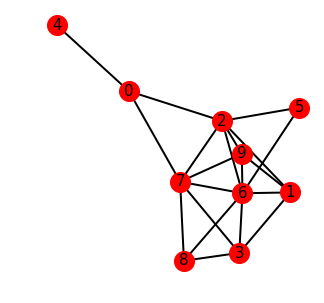

In [15]:
display_nxgraph(M2)

In [16]:
communs = maximum_common_induced_subgraph(M,M2,4,False,True)

Combinations in construction...
Combinations number Graph 1 :
848
Combinations number Graph 2 :
848
Done!
Extracting All Induced Subgraphs...
Done!
Final Subgraphs Number after filtering :
for graph 1 :624
for graph 2 :442
Distances...
Done!
Found 1 maximum common induced subgraphs.
Maximum Number of nodes : 6
Time elapsed :99.26658296585083


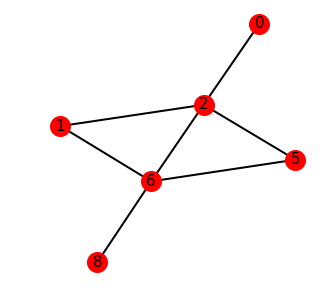

In [17]:
display_nxgraph(communs[0][1])

In [18]:
communs2 = maximum_common_induced_subgraph(M,M2,4,True,True)

Combinations in construction...
Combinations number Graph 1 :
848
Combinations number Graph 2 :
848
Done!
Max Clique Filter Enabled...
Extracting All Induced Subgraphs for each max_clique...
Done!
Final Subgraphs Number after filtering with Max Cliques :
for graph 1 :927
for graph 2 :301
Distances...
Done!
Found 2 maximum common induced subgraphs.
Maximum Number of nodes : 6
Time elapsed :89.22125291824341


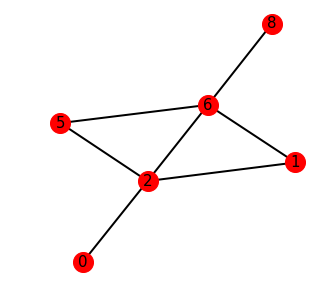

In [24]:
display_nxgraph(communs2[0][1])

## Conclusion

Here, only 10 secondes was saved between the two approachs but sometimes you can reduce by a hundred the time elapsed if you use the max clique filter !

## To be sure to have the best results :

Don't use max filter but i don't recommend to take more than 15 nodes to not explode your machine.

## To Save Time :

Max Filter can find the best solution but it's not a 100% accuracy (i've experimented about 80% accuracy in general by comparing the two kinds of approachs). It is a way to save computing time.